# Chapter 3
## Classification
p. 85

In [1]:
# download the data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X,y = mnist["data"], mnist["target"]
X.shape
# 70000 images with 784 features -> 24 x 24 pixels

(70000, 784)

In [3]:
y.shape # labels

(70000,)

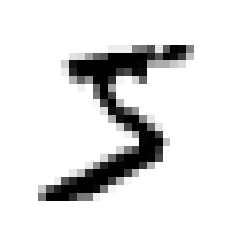

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

y[0]
X = X.to_numpy()
some_digit = X[0] # first image
some_digit_image = some_digit.reshape(28, 28) # reshape to 28 x 28 array

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
# cast y from string to integer
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Train the classifier
p.88
we focus on a one digit identifier

In [8]:
# let's try to identify one digit - the 5
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

Pick a classifier: We use Stochastic Gradient Descent (SGD) -> efficient because it deals with training sets independently (one at a time) -> also good for online learning

In [9]:
# lets create an SGDClassifier and train it on the whole training set
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
# now it can be used to detect images of number 5
sgd_clf.predict([some_digit])  # that was the first dataset

array([ True])

## Performance measures
p. 88
Evaluating classifiers is trickier than evaluating regressors

### Measuring accuracy using Cross-Validation

In [11]:
# To have more control one can also implement a cross validation himself
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(shuffle=True, n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
# Lets use cross_validation_score to evaluate the SGDClassifier model using 3 folds
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# Don't be confused by the 95 % accuracy. Since only 10 % of the whole datasets are "5" the accuracy of a "not 5" 
# dummy classifier (which simply classifies everything as not 5) has an accuracy of 90 %.

### Confusion Matrix
p. 90 
Much better performance evaluation. The general idea is to count the number of times instances of class A are classified as class B. e.g. to know the number of times the classifier confused images of 5s as 3s, one would look  in the fifth row and third column of the confusion matrix.

In [14]:
# get set of predictions to compare the to actual targets
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `cross_val_score()`, `cross_val_predict()` performs K-folds cross_validation. But it returns predictions that have been made on each test folds (not evaluation scores). <br>
This means you get clean (model never saw the data during training) predictions for each instance of the training set

In [15]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

The first row: Non-5 images (negative class). <br>
* 53892 true negatives (correctly as not 5 classified) -> (TN)
* 687 false positives (wrongly as 5 classified) -> (FP)

The second row: 5s images (positive class. <br>
* 1891 false negatives (wrongly as not 5 classified) -> (FN)
* 3530 true positives (correclty as 5 classified) -> (TP)

### Precision and Recall
p.92
precision = TP / (TP + FP)
recall = TP / (TP + FN)

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891)

0.6511713705958311

<b>How to read:</b> 5-detector only correct 83.7% of the time. It detects only 65.1% of the 5s.

In [18]:
# Combine these two values to the F1 score. (Harmonic mean)
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [22]:
# specify to get decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [23]:
# Precision recall function to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

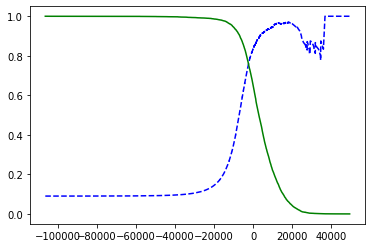

In [25]:
# Plot the curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precisions")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recalls")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

## The ROC Curve
p.97
Receiver operating characteristic (ROC)
plots the <b>true positive rate (alias recall)</b> against the <b> Truen negative rate (TNR, or, 1-specificy)</b>.
<br>It therefor plots <b>sensitivity (recall) against 1-specificy </b>

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

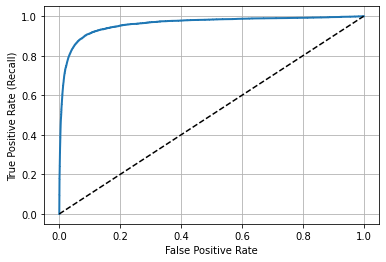

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--") # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

Comparing classifiers can be done with the <i> area under the curve </i> (AUC). <br>
* perfect classifier: AUC = 1
* purely random classifier: AUC = 0.5

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Choose 
* Precision/Recall Curve: When the positive class is rare, or when you care more about the false positives than about the false negatives
* Otherwise use ROC

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [41]:
y_scores_forest = y_probas_forest[:,1]  # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

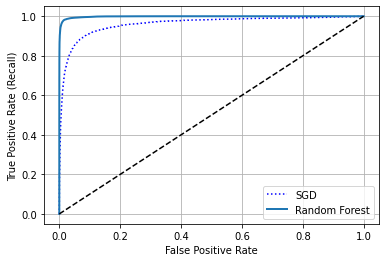

In [45]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

Random Forest ROC Curve looks much better than the SGD classifiers one. It comes much close to the top-left corner. As a result its ROC AUC score is also significantly better:

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [49]:
# precision
precision_score(y_train_5, y_probas_forest)

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets